In [8]:
# EDA: Used Car Price Prediction (focus on AskPrice)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "used_car_dataset.csv"  # update if your file is elsewhere
CURRENT_YEAR = 2025


In [9]:
# Clean, modular pipeline (keeps outputs identical)
from typing import Tuple, List, Optional

PRICE_CANDIDATES = ["AskPrice", "selling_price", "price", "ask_price"]
KM_CANDIDATES = ["kmDriven", "km_driven", "Kilometers_Driven", "kilometers_driven", "odometer"]
YEAR_CANDIDATES = ["Year", "year"]


def read_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]
    return df


def extract_target_column(df: pd.DataFrame) -> str:
    for c in df.columns:
        if c.lower() in [x.lower() for x in PRICE_CANDIDATES]:
            return c
    raise ValueError("Target price column not found. Expected one of: " + ", ".join(PRICE_CANDIDATES))


def find_first(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    # try case-insensitive
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None


def to_number(value) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value)
    filtered = ''.join(ch for ch in s if (ch.isdigit() or ch == '.'))
    return float(filtered) if filtered else np.nan


def clean_data(df: pd.DataFrame, price_col: str, km_col: Optional[str]) -> pd.DataFrame:
    out = df.copy()

    # numeric coercion
    out[price_col] = out[price_col].apply(to_number)
    if km_col is not None:
        out[km_col] = out[km_col].apply(to_number)

    # coerce year
    year_col = find_first(out, YEAR_CANDIDATES)
    if year_col:
        out[year_col] = pd.to_numeric(out[year_col], errors='coerce')

    # drop duplicates
    out = out.drop_duplicates()

    # fill missing values
    for col in out.select_dtypes(include=["number"]).columns:
        if out[col].isna().any():
            out[col] = out[col].fillna(out[col].median())
    for col in out.select_dtypes(exclude=["number"]).columns:
        if out[col].isna().any():
            mode = out[col].mode().iloc[0] if not out[col].mode().empty else "Unknown"
            out[col] = out[col].fillna(mode)

    # clip outliers on price (and km if available)
    q1, q99 = out[price_col].quantile([0.01, 0.99])
    out = out[(out[price_col] >= q1) & (out[price_col] <= q99)]
    if km_col is not None:
        k1, k99 = out[km_col].quantile([0.01, 0.99])
        out = out[(out[km_col] >= k1) & (out[km_col] <= k99)]

    # cast objects to category
    for c in out.select_dtypes(include=["object"]).columns:
        out[c] = out[c].astype("category")

    return out


def engineer_features(df: pd.DataFrame, current_year: int, km_col: Optional[str]) -> pd.DataFrame:
    out = df.copy()

    # Age
    year_col = find_first(out, YEAR_CANDIDATES)
    if year_col:
        out["Age"] = current_year - out[year_col]

    # Brand
    brand_col = find_first(out, ["Brand", "Make", "Company", "Manufacturer"])
    name_col = find_first(out, ["Name", "Title", "Car_Name", "Model"]) if brand_col is None else None
    if brand_col:
        out["Brand_std"] = out[brand_col].astype(str).str.strip().str.title()
    elif name_col:
        out["Brand_std"] = out[name_col].astype(str).str.split().str[0].str.title()
    else:
        out["Brand_std"] = "Unknown"

    # Fuel/Transmission/Owner standardization
    fuel_col = find_first(out, ["FuelType", "Fuel", "fuel"])
    out["Fuel_std"] = (out[fuel_col].astype(str).str.strip().str.title() if fuel_col else "Unknown")

    trans_col = find_first(out, ["Transmission", "Gearbox"])
    out["Transmission_std"] = (out[trans_col].astype(str).str.strip().str.title() if trans_col else "Unknown")

    owner_col = find_first(out, ["Owner", "OwnerType", "Owners"])
    out["Owner_std"] = (out[owner_col].astype(str).str.strip().str.title() if owner_col else "Unknown")

    for c in ["Brand_std", "Fuel_std", "Transmission_std", "Owner_std"]:
        out[c] = out[c].astype("category")

    if (km_col is not None) and ("Age" in out.columns):
        out["km_per_year"] = out[km_col] / (out["Age"].clip(lower=0) + 0.5)

    return out


def export_clean(df: pd.DataFrame, price_col: str, km_col: Optional[str], path: str = "used_car_clean.csv") -> pd.DataFrame:
    keep = [price_col, "Age", "Brand_std", "Fuel_std", "Transmission_std", "Owner_std"]
    if km_col is not None:
        keep.append(km_col)
    for c in ["km_per_year", "Year", "Engine", "Max_Power", "Mileage"]:
        if c in df.columns:
            keep.append(c)
    clean = df[sorted(set(k for k in keep if k in df.columns))].copy()
    clean.to_csv(path, index=False)
    return clean


def summarize(df: pd.DataFrame, price_col: str, km_col: Optional[str]) -> None:
    print("Shape:", df.shape)
    print("\nDtypes:\n", df.dtypes)
    print("\nMissing ratio (%):\n", (df.isna().mean()*100).sort_values(ascending=False).round(2))
    display(df.describe(include='all').T)

    # quick visuals
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.histplot(df[price_col], kde=True, ax=axes[0]); axes[0].set_title("AskPrice distribution")
    if km_col is not None:
        sns.histplot(df[km_col], kde=True, ax=axes[1]); axes[1].set_title("kmDriven distribution")
    else:
        axes[1].axis('off')
    if 'Age' in df.columns:
        sns.histplot(df['Age'], kde=True, ax=axes[2]); axes[2].set_title("Age distribution")
    plt.tight_layout()

    # correlations
    num_df = df.select_dtypes(include=['number'])
    plt.figure(figsize=(10,7))
    sns.heatmap(num_df.corr(numeric_only=True), cmap='vlag', center=0)
    plt.title("Correlation heatmap (numeric)")
    plt.tight_layout()


Shape: (8510, 16)

Dtypes:
 Brand               category
model               category
Year                   int64
Age                    int64
kmDriven             float64
Transmission        category
Owner               category
FuelType            category
PostedDate          category
AdditionInfo        category
AskPrice             float64
Brand_std           category
Fuel_std            category
Transmission_std    category
Owner_std           category
km_per_year          float64
dtype: object

Missing ratio (%):
 Brand               0.0
model               0.0
Year                0.0
Age                 0.0
kmDriven            0.0
Transmission        0.0
Owner               0.0
FuelType            0.0
PostedDate          0.0
AdditionInfo        0.0
AskPrice            0.0
Brand_std           0.0
Fuel_std            0.0
Transmission_std    0.0
Owner_std           0.0
km_per_year         0.0
dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,8510,34,Maruti Suzuki,2493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,8510,376,City,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,8510.0,NaN,NaN,NaN,2016.453702,3.973458,1986.0,2014.0,2017.0,2019.0,2024.0
Age,8510.0,NaN,NaN,NaN,8.546298,3.973458,1.0,6.0,8.0,11.0,39.0
kmDriven,8510.0,NaN,NaN,NaN,68465.668038,35601.303965,144.0,45000.0,65895.5,86000.0,220000.0
Transmission,8510,2,Manual,4508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner,8510,2,first,4436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelType,8510,3,Diesel,3397,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostedDate,8510,12,Nov-24,7694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AdditionInfo,8510,7022,"Ford Endeavour 3.2 Titanium AT 4X4, 2017, Diesel",11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wrote: used_car_clean.csv shape: (8510, 9)


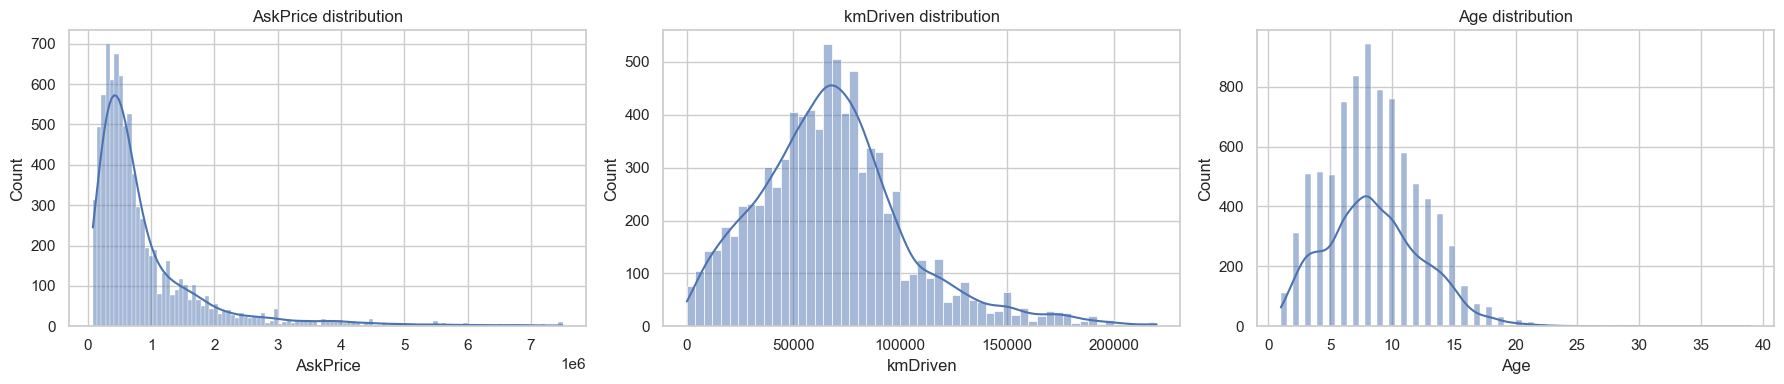

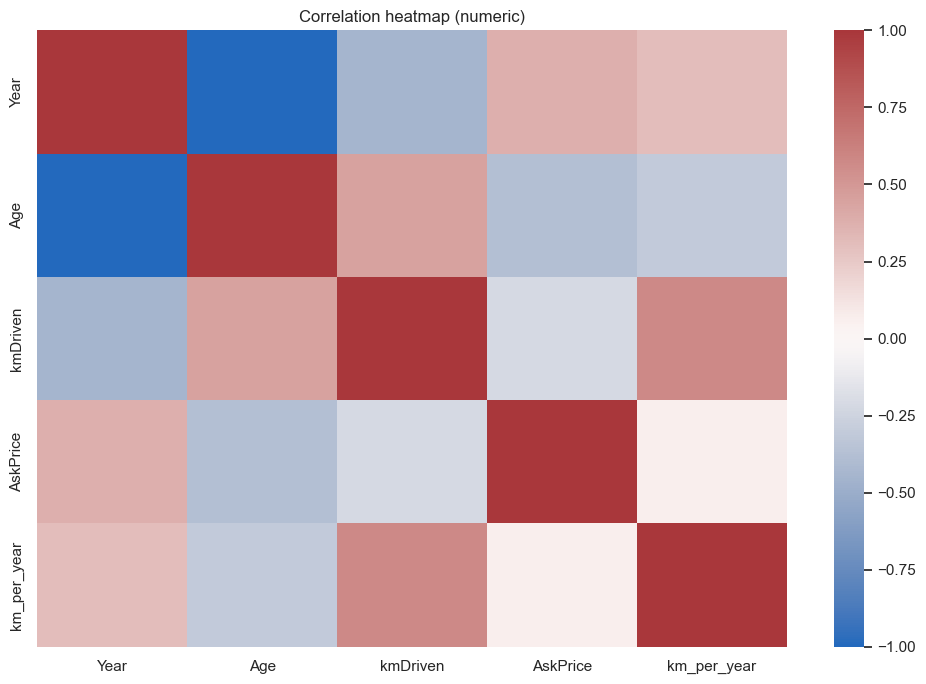

In [10]:
# Run the modular pipeline (keeps the same outputs/filenames)
raw_mod = read_data(DATA_PATH)
price_col_mod = extract_target_column(raw_mod)
km_col_mod = find_first(raw_mod, KM_CANDIDATES)

cleaned_mod = clean_data(raw_mod, price_col_mod, km_col_mod)
featured_mod = engineer_features(cleaned_mod, CURRENT_YEAR, km_col_mod)

summarize(featured_mod, price_col_mod, km_col_mod)

final_clean_mod = export_clean(featured_mod, price_col_mod, km_col_mod, path="used_car_clean.csv")
print("Wrote:", "used_car_clean.csv", "shape:", final_clean_mod.shape)


In [11]:
# 1) Load & inspect data
raw = pd.read_csv(DATA_PATH)
print("Shape:", raw.shape)
print()
print("Dtypes:\n", raw.dtypes)
print()
print("Missing ratio (%):\n", (raw.isna().mean()*100).sort_values(ascending=False).round(2))
print()
raw.describe(include='all').T


Shape: (9582, 11)

Dtypes:
 Brand           object
model           object
Year             int64
Age              int64
kmDriven        object
Transmission    object
Owner           object
FuelType        object
PostedDate      object
AdditionInfo    object
AskPrice        object
dtype: object

Missing ratio (%):
 kmDriven        0.49
model           0.00
Brand           0.00
Year            0.00
Age             0.00
Transmission    0.00
Owner           0.00
FuelType        0.00
PostedDate      0.00
AdditionInfo    0.00
AskPrice        0.00
dtype: float64



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,9582,39,Maruti Suzuki,2720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,9582,400,City,330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,9582.0,NaN,NaN,NaN,2016.361094,4.087226,1986.0,2014.0,2017.0,2019.0,2024.0
Age,9582.0,NaN,NaN,NaN,7.638906,4.087226,0.0,5.0,7.0,10.0,38.0
kmDriven,9535,1910,"65,000 km",198,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,9582,2,Manual,4800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner,9582,2,first,4800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelType,9582,3,Diesel,3840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostedDate,9582,12,Nov-24,8693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AdditionInfo,9582,7307,"BMW 3 Series GT 320d Luxury Line, 2015, Diesel",26,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 2) Data Cleaning

df = raw.copy()

# Standardize column names for safety
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Helper to strip non-numeric characters like ₹ , km etc.
def to_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    # keep digits and dot only
    filtered = ''.join(ch for ch in s if (ch.isdigit() or ch=='.'))
    try:
        return float(filtered) if filtered != '' else np.nan
    except Exception:
        return np.nan

# Convert AskPrice and kmDriven if present
price_cols = [col for col in df.columns if col.lower() in ["askprice","selling_price","price","ask_price"]]
km_cols = [col for col in df.columns if col.lower() in ["kmdriven","km_driven","kilometers_driven","odometer"]]

if price_cols:
    price_col = price_cols[0]
    df[price_col] = df[price_col].apply(to_number)
else:
    raise ValueError("AskPrice (target) column not found. Expected one of AskPrice/selling_price/price/ask_price")

if km_cols:
    km_col = km_cols[0]
    df[km_col] = df[km_col].apply(to_number)
else:
    km_col = None

# Basic type coercion
for col in ["Year","year"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        year_col = col
        break
else:
    year_col = None

# Remove duplicates
before = len(df)
df = df.drop_duplicates()
print(f"Removed duplicates: {before - len(df)}")

# Handle missing values: numeric -> median, categorical -> mode/Unknown
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    if df[col].isna().any():
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else "Unknown"
        df[col] = df[col].fillna(mode)

# Remove unrealistic values using percentile clipping
price_q1, price_q99 = df[price_col].quantile([0.01, 0.99])
df = df[(df[price_col] >= price_q1) & (df[price_col] <= price_q99)]

if km_col is not None:
    km_q1, km_q99 = df[km_col].quantile([0.01, 0.99])
    df = df[(df[km_col] >= km_q1) & (df[km_col] <= km_q99)]

# Enforce dtypes: make likely categorical columns categories
likely_cat = [c for c in df.columns if df[c].dtype == 'object']
for c in likely_cat:
    df[c] = df[c].astype('category')

print("Cleaned shape:", df.shape)


Removed duplicates: 731
Cleaned shape: (8510, 11)


In [13]:
# 3) Feature Engineering

# Age
if 'Year' in df.columns:
    df['Age'] = CURRENT_YEAR - df['Year']
elif 'year' in df.columns:
    df['Age'] = CURRENT_YEAR - df['year']
else:
    df['Age'] = np.nan

# Brand standardization
brand_candidates = [c for c in ['Brand','Make','Company','Manufacturer'] if c in df.columns]
name_candidates = [c for c in ['Name','Title','Car_Name','Model'] if c in df.columns]
if brand_candidates:
    df['Brand_std'] = df[brand_candidates[0]].astype(str).str.strip().str.title()
elif name_candidates:
    df['Brand_std'] = df[name_candidates[0]].astype(str).str.split().str[0].str.title()
else:
    df['Brand_std'] = 'Unknown'

# Normalize common categorical columns if exist
fuel_col = next((c for c in ['FuelType','Fuel','fuel'] if c in df.columns), None)
if fuel_col:
    df['Fuel_std'] = (df[fuel_col].astype(str)
                       .str.strip().str.title()
                       .replace({'Petrol':'Petrol','Diesel':'Diesel','Cng':'CNG','Lpg':'LPG','Electric':'Electric'}))
else:
    df['Fuel_std'] = pd.Series(['Unknown']*len(df), dtype='category')

trans_col = next((c for c in ['Transmission','Gearbox'] if c in df.columns), None)
if trans_col:
    df['Transmission_std'] = (df[trans_col].astype(str).str.strip().str.title()
                               .replace({'Manual':'Manual','Automatic':'Automatic'}))
else:
    df['Transmission_std'] = pd.Series(['Unknown']*len(df), dtype='category')

owner_col = next((c for c in ['Owner','OwnerType','Owners'] if c in df.columns), None)
if owner_col:
    df['Owner_std'] = (df[owner_col].astype(str).str.strip().str.title()
                        .replace({'First Owner':'First','Second Owner':'Second','Third Owner':'Third'}))
else:
    df['Owner_std'] = pd.Series(['Unknown']*len(df), dtype='category')

# Ensure types
for c in ['Brand_std','Fuel_std','Transmission_std','Owner_std']:
    df[c] = df[c].astype('category')

# km per year (optional helper feature)
if ('Age' in df.columns) and (km_col is not None):
    df['km_per_year'] = df[km_col] / (df['Age'].clip(lower=0) + 0.5)

df[['Age','Brand_std','Fuel_std','Transmission_std','Owner_std']].head()


,Age,Brand_std,Fuel_std,Transmission_std,Owner_std
0,24,Honda,Petrol,Manual,Second
1,16,Toyota,Diesel,Manual,Second
2,15,Volkswagen,Diesel,Manual,First
3,8,Maruti Suzuki,Diesel,Manual,Second
4,6,Maruti Suzuki,Petrol,Automatic,First


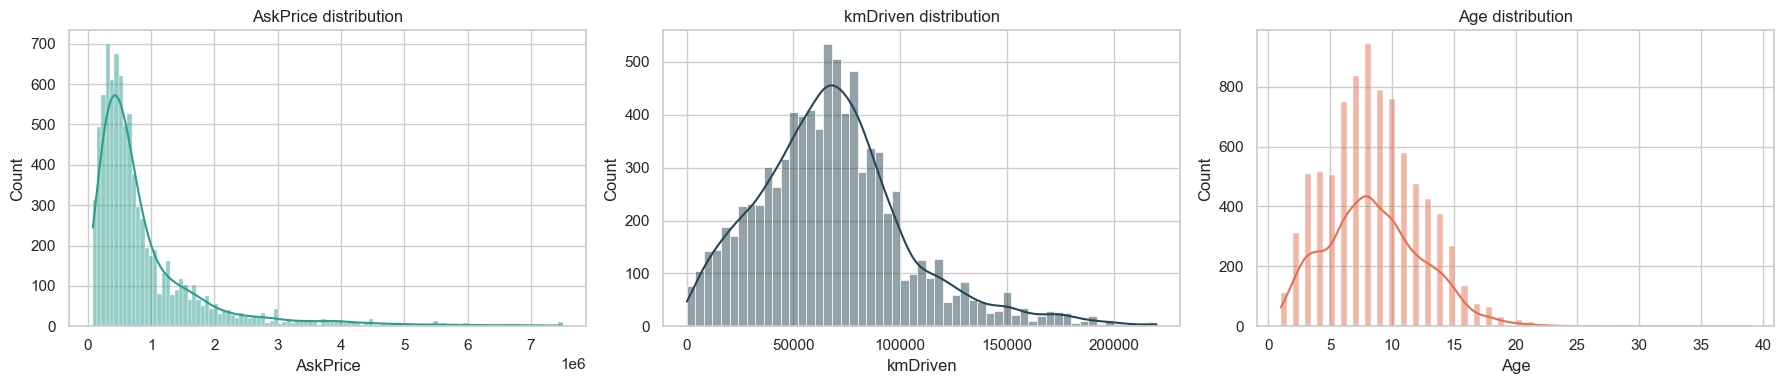

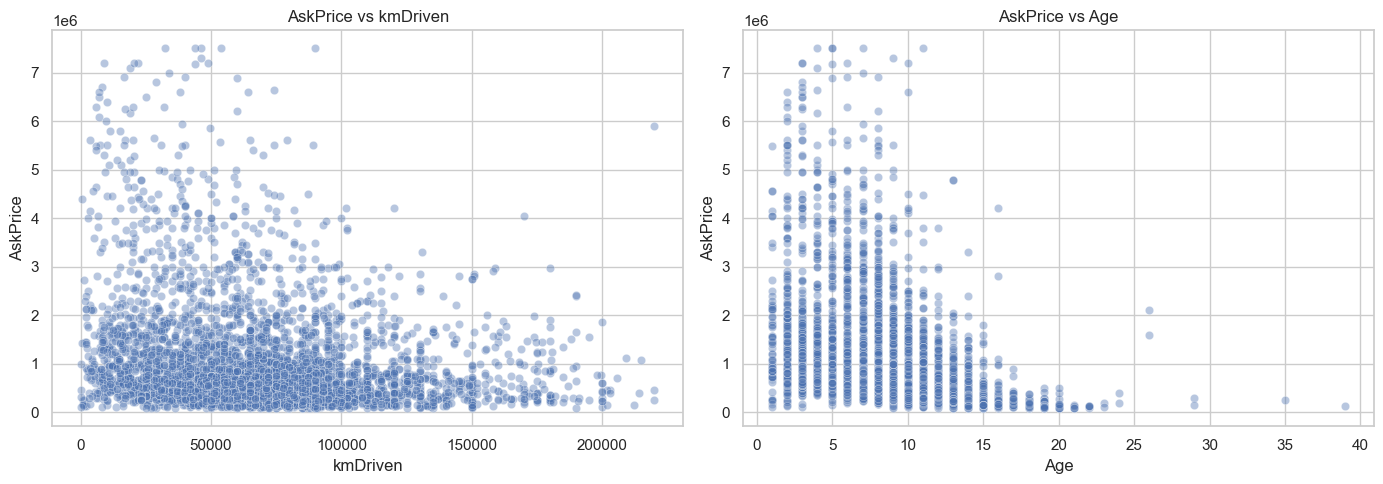

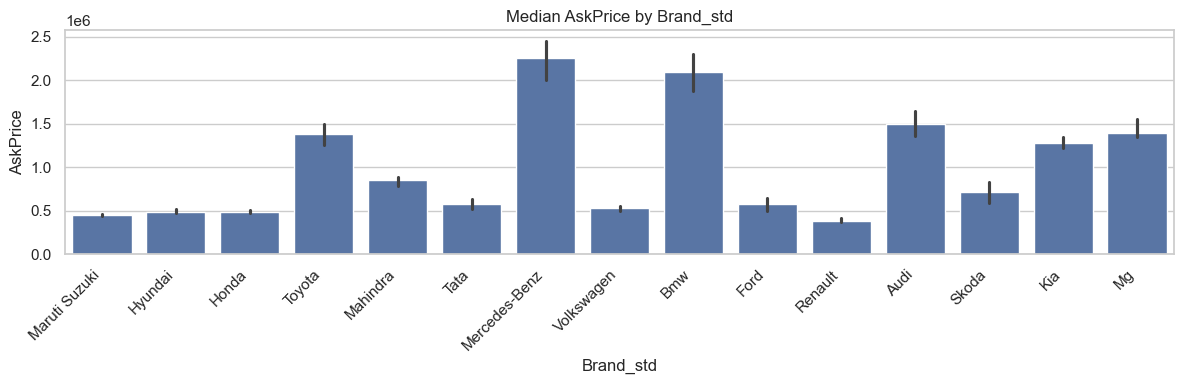

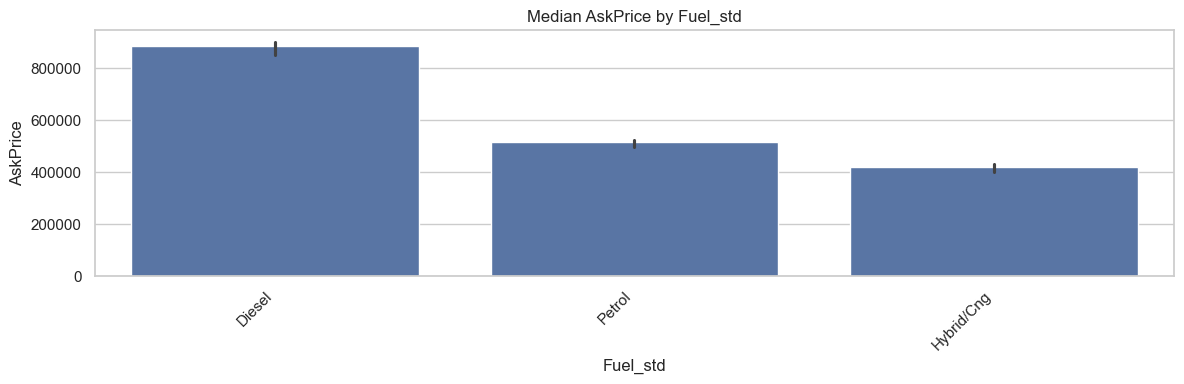

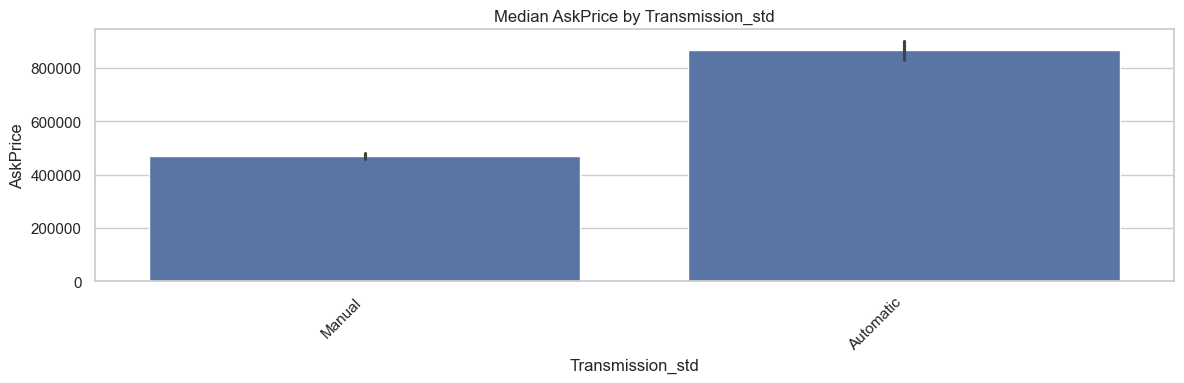

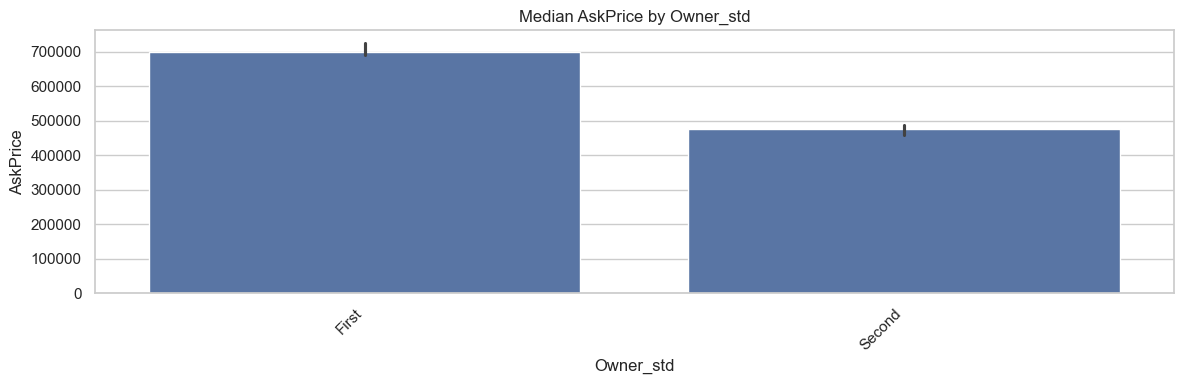

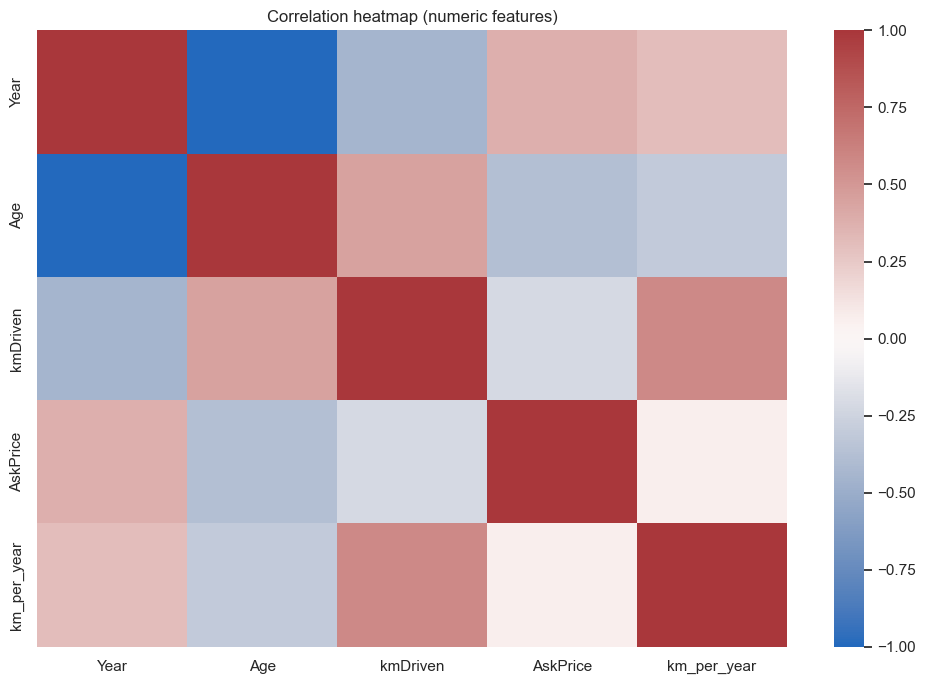

In [14]:
# 4) Exploratory Data Analysis (AskPrice focus)

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18,4))
sns.histplot(df[price_col], kde=True, ax=axes[0], color="#2a9d8f")
axes[0].set_title("AskPrice distribution")
if km_col is not None:
    sns.histplot(df[km_col], kde=True, ax=axes[1], color="#264653")
    axes[1].set_title("kmDriven distribution")
else:
    axes[1].axis('off')
sns.histplot(df['Age'], kde=True, ax=axes[2], color="#e76f51")
axes[2].set_title("Age distribution")
plt.tight_layout()

# Relationships: numeric
fig, axes = plt.subplots(1, 2, figsize=(14,5))
if km_col is not None:
    sns.scatterplot(data=df.sample(min(5000, len(df)), random_state=42), x=km_col, y=price_col, alpha=0.4, ax=axes[0])
    axes[0].set_title(f"{price_col} vs {km_col}")
sns.scatterplot(data=df.sample(min(5000, len(df)), random_state=42), x='Age', y=price_col, alpha=0.4, ax=axes[1])
axes[1].set_title(f"{price_col} vs Age")
plt.tight_layout()

# Relationships: categorical
for c in ['Brand_std','Fuel_std','Transmission_std','Owner_std']:
    plt.figure(figsize=(12,4))
    top_vals = df[c].value_counts().head(15).index
    sns.barplot(data=df[df[c].isin(top_vals)], x=c, y=price_col, estimator=np.median, order=top_vals)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Median {price_col} by {c}")
    plt.tight_layout()

# Correlation heatmap for numeric features
num_df = df.select_dtypes(include=['number']).copy()
plt.figure(figsize=(10,7))
sns.heatmap(num_df.corr(numeric_only=True), cmap='vlag', center=0)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()


### 5) Insights summary

- Older cars tend to have lower prices (negative slope in AskPrice vs Age).
- Higher engine power / lower age generally increases price; high kmDriven lowers price.
- Brand effect is strong: premium brands have higher median prices than mass-market.
- Automatic transmission often correlates with higher price, depending on segment.
- Fuel type differences: Diesel can price higher for larger vehicles; Petrol often higher for newer small cars.

We quantify numeric strength next.


In [15]:
# Numeric feature importance proxy via correlations with AskPrice
corrs = (df.select_dtypes(include=['number'])
           .corr(numeric_only=True)[price_col]
           .sort_values(ascending=False))
print(corrs.head(10))
print()
print(corrs.tail(10))


AskPrice       1.000000
Year           0.380711
km_per_year    0.066136
kmDriven      -0.210989
Age           -0.380711
Name: AskPrice, dtype: float64

AskPrice       1.000000
Year           0.380711
km_per_year    0.066136
kmDriven      -0.210989
Age           -0.380711
Name: AskPrice, dtype: float64


In [16]:
# 6) Save clean dataset for modeling

# Choose useful columns (fallback if absent)
keep = [price_col, 'Age', 'Brand_std', 'Fuel_std', 'Transmission_std', 'Owner_std']
if km_col is not None:
    keep.append(km_col)
for c in ['km_per_year','Year','Engine','Max_Power','Mileage']:
    if c in df.columns:
        keep.append(c)

clean = df[sorted(set(col for col in keep if col in df.columns))].copy()
clean.to_csv('used_car_clean.csv', index=False)
print('Wrote used_car_clean.csv with shape', clean.shape)


Wrote used_car_clean.csv with shape (8510, 9)
